# Data pre-processing

In [1]:
# Data , data preprocessing and basic model from kaggale
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
!pip install numpy==1.16.1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

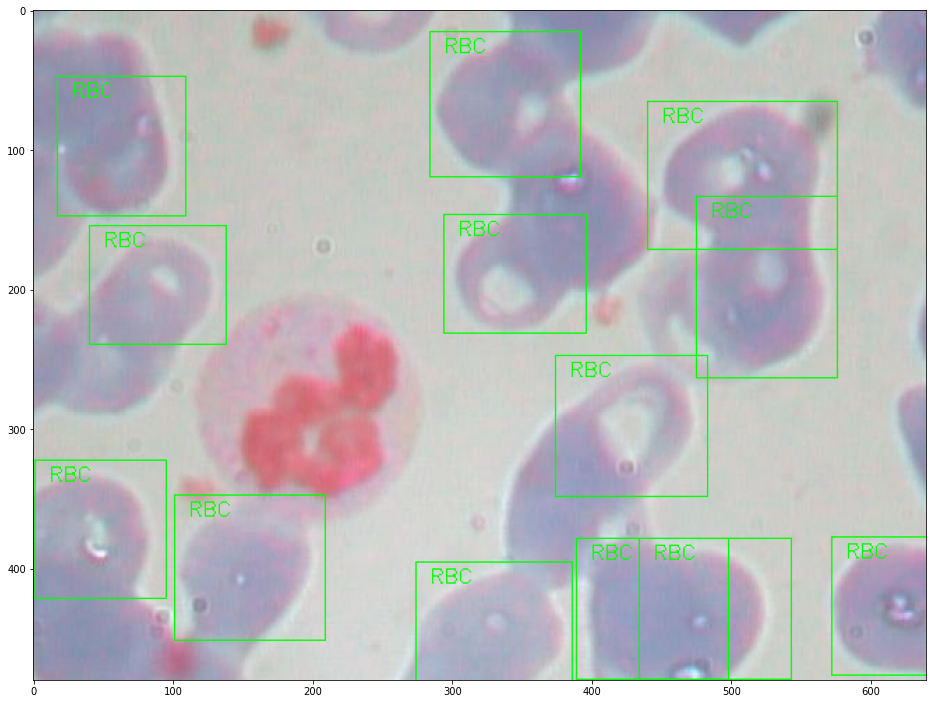

In [4]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("/content/drive/My Drive/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("/content/drive/My Drive/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

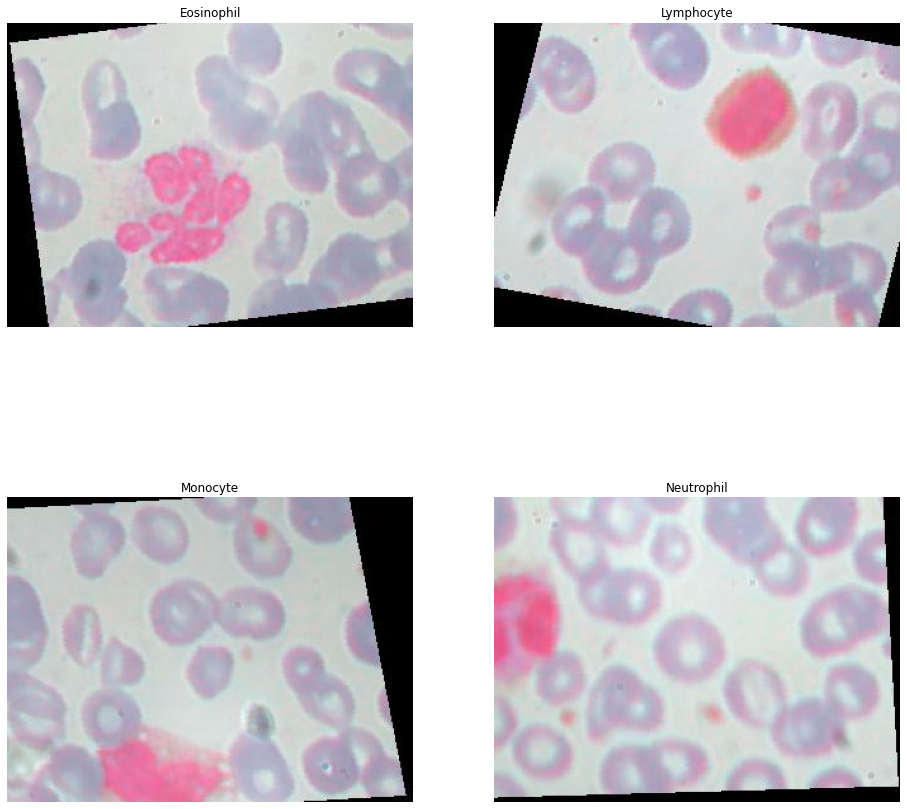

In [5]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = '/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = '/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = '/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = '/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

[  3  88  33  21 207]


Text(0, 0.5, 'Counts')

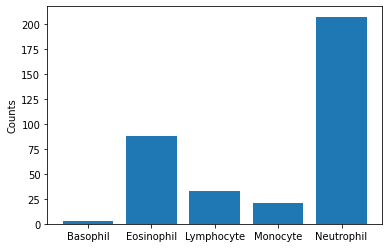

In [6]:
reader = csv.reader(open('/content/drive/My Drive/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

In [5]:
from tqdm import tqdm
from skimage.transform import resize
from skimage import data
from PIL import Image

def get_data(folder):
    #    Load the data and labels from the given folder.
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('/content/drive/My Drive/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

  1%|          | 23/2483 [00:00<00:11, 222.44it/s]

LYMPHOCYTE


  1%|          | 21/2499 [00:00<00:12, 204.94it/s]

NEUTROPHIL


  1%|          | 23/2497 [00:00<00:11, 222.19it/s]

EOSINOPHIL


  1%|          | 21/2478 [00:00<00:11, 209.22it/s]

MONOCYTE


  4%|▍         | 27/624 [00:00<00:02, 260.33it/s]

NEUTROPHIL


  4%|▎         | 23/620 [00:00<00:02, 226.81it/s]

MONOCYTE


  4%|▍         | 26/623 [00:00<00:02, 254.49it/s]

EOSINOPHIL


  4%|▎         | 23/620 [00:00<00:02, 226.70it/s]

LYMPHOCYTE


100%|██████████| 620/620 [00:02<00:00, 247.98it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


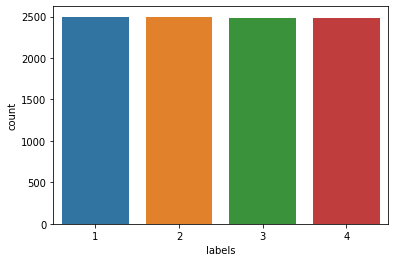

In [9]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

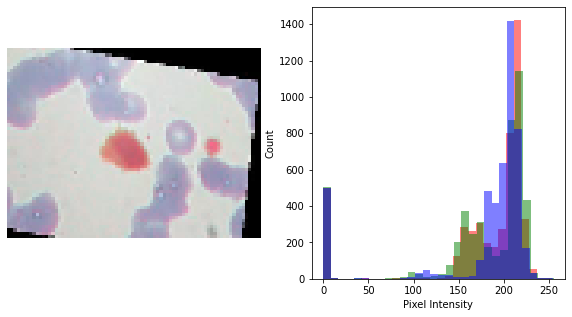

In [10]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

In [6]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

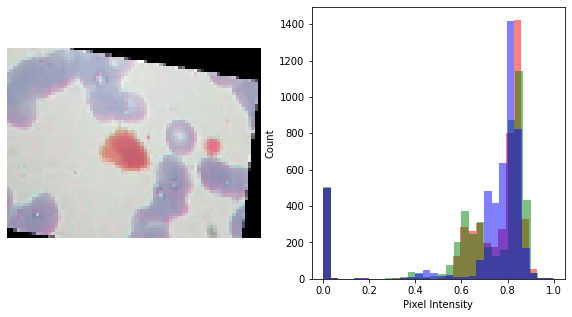

In [12]:
plotHistogram(X_train[1])

# Using Basic CNN algorithm

In [13]:
# Helper Functions  

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)



In [14]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')



In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [16]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc']) # acc instead of accurarcy
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Epoch 1/30
312/311 [==============================] - 13s 43ms/step - loss: 1.4508 - accuracy: 0.2714 - val_loss: 1.3727 - val_accuracy: 0.2975
Epoch 2/30
312/311 [==============================] - 13s 41ms/step - loss: 1.3387 - accuracy: 0.3402 - val_loss: 1.2128 - val_accuracy: 0.4568
Epoch 3/30
312/311 [==============================] - 13s 42ms/step - loss: 1.2355 - accuracy: 0.4178 - val_loss: 1.0686 - val_accuracy: 0.4801
Epoch 4/30
312/311 [==============================] - 13s 41ms/step - loss: 1.1510 - accuracy: 0.4594 - val_loss: 0.9864 - val_accuracy: 0.5227
Epoch 5/30
312/311 [==============================] - 13s 41ms/step - loss: 1.0819 - accuracy: 0.5082 - val_loss: 1.2213 - val_accuracy: 0.4371
Epoch 6/30
312/311 [==============================] - 13s 41ms/step - loss: 1.0148 - accuracy: 0.5391 - val_loss: 0.8733 - val_accuracy: 0.5879
Epoch 7/30
312/311 [==============================] - 13s 41ms/step - loss: 0.9217 - accuracy: 0.5782 - val_loss: 0.8080 - val_accuracy:

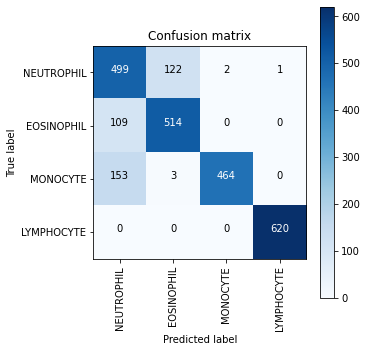

In [58]:
import keras
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

def runCNN(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=False)  
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runCNN(X_train,y_trainHot,X_test,y_testHot,1)

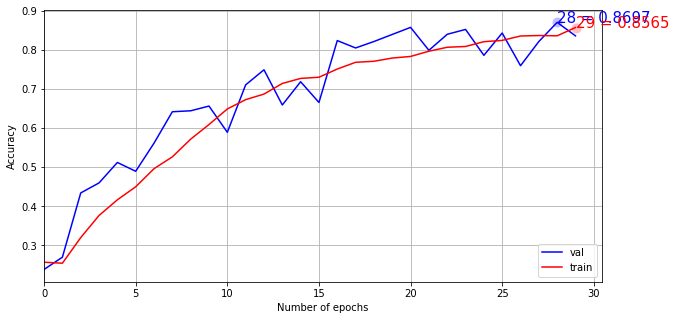

In [49]:
plotKerasLearningCurve()
plt.show()

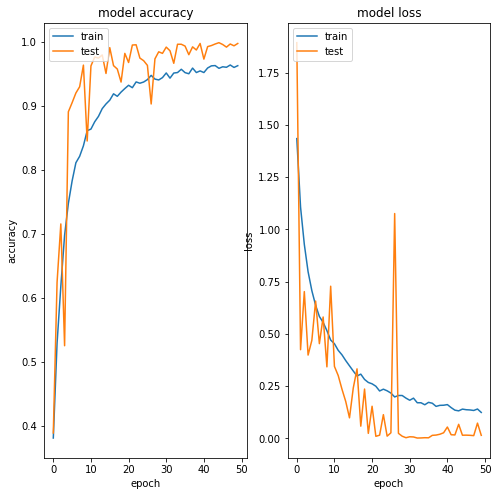

In [55]:
plot_learning_curve(history)
plt.show()

#                       VGG16 implementation 





In [7]:
from keras.models import Sequential,Model
from keras.layers import Activation
from keras.layers.core import Dense,Flatten,Dropout
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam, RMSprop , SGD
import keras 
import keras.backend as B
import numpy as np
import keras.applications as A
import matplotlib.pyplot as plt
%matplotlib inline

import os
from keras import regularizers

In [65]:
train_path = "/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN/"
test_path = "/content/drive/My Drive/dataset2-master/dataset2-master/images/TEST/"

In [66]:
inputs = (240,320,3)


In [67]:
vgg = A.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=inputs)

58892288/58889256 [==============================] - 2s 0us/step


In [68]:
model = Sequential()
for layer in vgg.layers[:-4]:
  layer.trainable=False

In [69]:
for layer in vgg.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7584771588> False
<keras.layers.convolutional.Conv2D object at 0x7f75847715c0> False
<keras.layers.convolutional.Conv2D object at 0x7f7584771908> False
<keras.layers.pooling.MaxPooling2D object at 0x7f75847717b8> False
<keras.layers.convolutional.Conv2D object at 0x7f7584327240> False
<keras.layers.convolutional.Conv2D object at 0x7f758431d0b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7584318128> False
<keras.layers.convolutional.Conv2D object at 0x7f7584318ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f758432a390> False
<keras.layers.convolutional.Conv2D object at 0x7f758432aef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f758432e978> False
<keras.layers.convolutional.Conv2D object at 0x7f758432e7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f75843354a8> False
<keras.layers.convolutional.Conv2D object at 0x7f7584335da0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f75842bcac8>

In [70]:
model.add(vgg)
 
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 10, 512)        14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 35840)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35840)             143360    
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1146912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_27 (Dense)             (None, 16)               

In [71]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest', validation_split=0.25)


validation_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 32
val_batchsize = 32

In [72]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=train_batchsize,
        class_mode='categorical', subset = "training")
 
validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False,
    subset='validation')

Found 7470 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [73]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

In [74]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=80,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)

Epoch 1/80
233/233 [==============================] - 200s 859ms/step - loss: 1.5196 - acc: 0.3303 - val_loss: 1.4562 - val_acc: 0.4663
Epoch 2/80
233/233 [==============================] - 200s 860ms/step - loss: 1.2526 - acc: 0.4418 - val_loss: 0.8119 - val_acc: 0.5996
Epoch 3/80
233/233 [==============================] - 203s 870ms/step - loss: 1.0611 - acc: 0.5563 - val_loss: 0.4631 - val_acc: 0.4688
Epoch 4/80
233/233 [==============================] - 202s 866ms/step - loss: 0.9181 - acc: 0.6444 - val_loss: 0.5591 - val_acc: 0.7418
Epoch 5/80
233/233 [==============================] - 202s 868ms/step - loss: 0.8055 - acc: 0.7319 - val_loss: 0.6310 - val_acc: 0.7328
Epoch 6/80
233/233 [==============================] - 200s 860ms/step - loss: 0.7096 - acc: 0.7783 - val_loss: 0.5545 - val_acc: 0.8843
Epoch 7/80
233/233 [==============================] - 197s 843ms/step - loss: 0.6310 - acc: 0.8200 - val_loss: 0.4082 - val_acc: 0.9246
Epoch 8/80
233/233 [============================

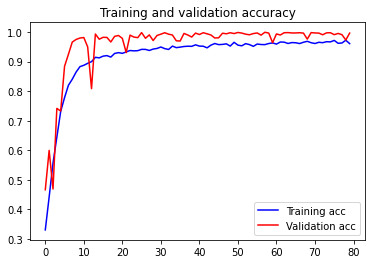

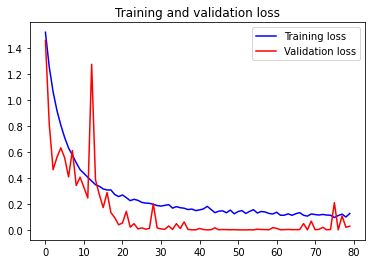

In [75]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


In [76]:
test_generator = test_datagen.flow_from_directory(
test_path,
target_size = (240, 320),
batch_size = 32,
class_mode = "categorical",
shuffle=False)

Found 2487 images belonging to 4 classes.


In [77]:
# Helper Method to draw confusion matrix for VGG 16
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, figname, normalize=False,  title='Confusion matrix',  cmap=plt.cm.Blues):
  import numpy as np
  import matplotlib.pyplot as plt
  import itertools
 
  if normalize:
   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   print("Normalized confusion matrix")
  else:
   print("Confusion matrix")
  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  #plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(figname)

In [78]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
category_names = {'NEUTROPHIL','EOSINOPHIL','MONOCYTE','LYMPHOCYTE'}
cm = confusion_matrix(test_generator.classes, y_pred)


Confusion matrix


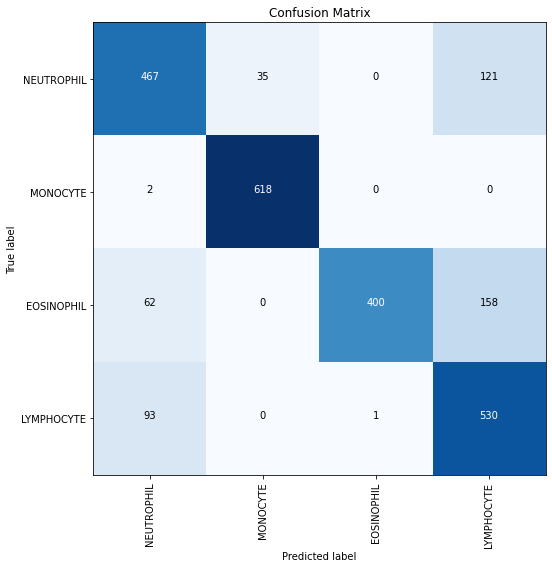

In [79]:
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

In [80]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 81.0% 


# Using Resnet50 Algorithm

In [19]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19, VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout
from keras.utils import to_categorical
import tensorflow as tf
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [53]:
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (60,80,3), classes = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'})

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [54]:
#Adding layers to the ResNet50
model_resnet=Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'),input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(5,activation=('softmax')))

#Summary of ResNet50 Model
model_resnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 3, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)              

In [55]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)

y_train=to_categorical(y_train)
y_val=to_categorical(y_train)
y_test=to_categorical(y_test)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
val_generator.fit(X_train)
test_generator.fit(X_test)


In [56]:
#Compiling ResNet50
#Defining the hyperparameters
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model_resnet.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01,  patience=3, min_lr=1e-5)

#Training the ResNet50 model
model_resnet.fit_generator(train_generator.flow(X_train, y_train, batch_size=batch_size), epochs=30, steps_per_epoch = X_train.shape[0]//batch_size, validation_data = val_generator.flow(X_train, y_train, batch_size = batch_size), validation_steps = 250, callbacks = [lrr], verbose=1)


Epoch 1/30
99/99 [==============================] - 66s 668ms/step - loss: 1.2978 - accuracy: 0.4256 - val_loss: 1.7458 - val_accuracy: 0.2562
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


99/99 [==============================] - 54s 549ms/step - loss: 0.5349 - accuracy: 0.7868 - val_loss: 2.1941 - val_accuracy: 0.2485
Epoch 3/30
99/99 [==============================] - 54s 549ms/step - loss: 0.2440 - accuracy: 0.9114 - val_loss: 3.6700 - val_accuracy: 0.2495
Epoch 4/30
99/99 [==============================] - 54s 544ms/step - loss: 0.1466 - accuracy: 0.9439 - val_loss: 8.5759 - val_accuracy: 0.2492
Epoch 5/30
99/99 [==============================] - 54s 544ms/step - loss: 0.0922 - accuracy: 0.9681 - val_loss: 6.5706 - val_accuracy: 0.2488
Epoch 6/30
99/99 [==============================] - 54s 540ms/step - loss: 0.0630 - accuracy: 0.9795 - val_loss: 3.9980 - val_accuracy: 0.2406
Epoch 7/30
99/99 [==============================] - 54s 544ms/step - loss: 0.0432 - accuracy: 0.9852 - val_loss: 1.9218 - val_accuracy: 0.3177
Epoch 8/30
99/99 [==============================] - 54s 542ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 1.9832 - val_accuracy: 0.4742
Epoch 9/30

In [24]:
def plot_confusion_matrix_res(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

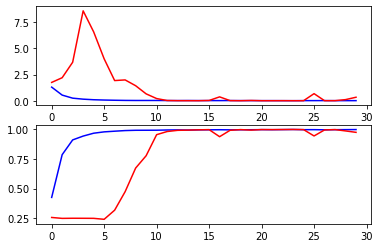

In [57]:
#Plotting the training and validation loss
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(model_resnet.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_resnet.history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(model_resnet.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_resnet.history.history['val_accuracy'],color='r',label='Validation Accuracy')


Confusion matrix, without normalization


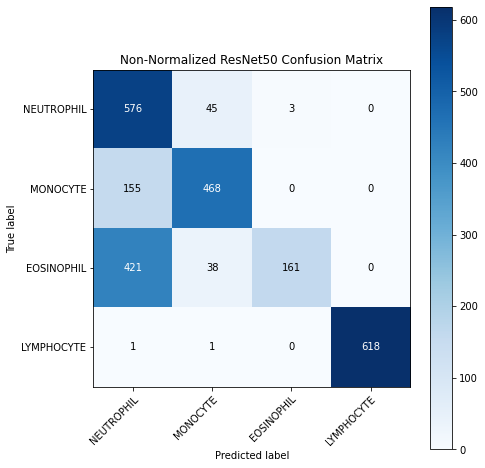

In [62]:
#Making prediction
y_pred3=model_resnet.predict_classes(X_test)
y_true=np.argmax(y_test,axis=1)

#Plotting the non normalized confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred3)

class_names={'NEUTROPHIL','EOSINOPHIL','MONOCYTE','LYMPHOCYTE'}
#Plotting non-normalized confusion matrix
plot_confusion_matrix_res(y_true, y_pred3, classes = class_names, title = 'Non-Normalized ResNet50 Confusion Matrix')


In [63]:
accuracy_score(y_true, y_pred3)

0.7330116606353035

# Fastai (fast.ai) implementation using Resnet50 over CNN

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [6]:
path = Path('/content/drive/My Drive/dataset2-master/dataset2-master/images/')
path.ls()

[PosixPath('/content/drive/My Drive/dataset2-master/dataset2-master/images/TRAIN'),
 PosixPath('/content/drive/My Drive/dataset2-master/dataset2-master/images/TEST'),
 PosixPath('/content/drive/My Drive/dataset2-master/dataset2-master/images/TEST_SIMPLE')]

In [8]:
data = ImageDataBunch.from_folder(path, train='TRAIN', test='TEST', valid_pct=0.20,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [10]:
data.c, len(data.train_ds), len(data.valid_ds)

(4, 8023, 2005)

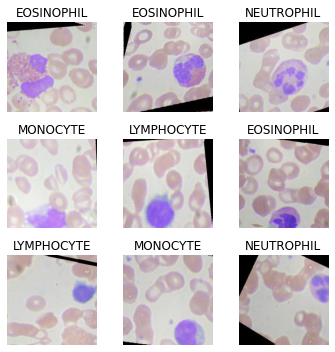

In [11]:
data.show_batch(rows=3, figsize=(5,5))

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [13]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.785343,0.238820,0.095262,19:13
1,0.350032,0.138908,0.052369,01:45


In [14]:
intr=ClassificationInterpretation.from_learner(learn)

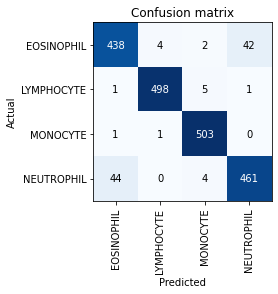

In [15]:
intr.plot_confusion_matrix()

In [16]:
learn.unfreeze()

In [17]:
learn.model_dir=Path('/content/drive/My Drive/')
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


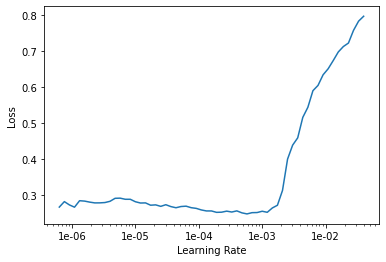

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(3, max_lr=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.139490,0.038098,0.012469,01:47
1,0.058111,0.008818,0.001995,01:48
2,0.020103,0.003710,0.000499,01:49


In [20]:
learn.save('model')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

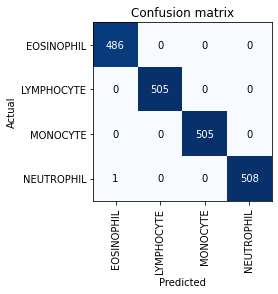

In [22]:
interp.plot_confusion_matrix()

# Using Resnet-Inception-V2 Algorithm

In [8]:
import keras
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import models, layers, applications
from keras.models import Model
from keras.utils import np_utils
from keras.optimizers import adam
from keras.layers import Input, BatchNormalization, ReLU, Add, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation 


In [9]:
def _inception_():

    inputs = Input(X_train.shape[1:])

    tower_one = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
    tower_one = layers.Conv2D(6, (1,1), activation='relu', border_mode='same')(tower_one)

    tower_two = layers.Conv2D(6, (1,1), activation='relu', border_mode='same')(inputs)
    tower_two = layers.Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_two)

    tower_three = layers.Conv2D(6, (1,1), activation='relu', border_mode='same')(inputs)
    tower_three = layers.Conv2D(6, (5,5), activation='relu', border_mode='same')(tower_three)
    
    x = keras.layers.concatenate([tower_one, tower_two, tower_three], axis=3)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(input = inputs, output = predictions)

    return model

In [10]:
def _resNet_():

    inputs = Input(X_train.shape[1:])
    
    h_1 = layers.Conv2D(6, (3,3), border_mode='same')(inputs)
    h_1 = BatchNormalization()(h_1)
    h_1 = ReLU()(h_1)

    h_2 = layers.Conv2D(6, (3,3), border_mode='same')(h_1)
    h_2 = BatchNormalization()(h_2)

    shortcut = layers.Conv2D(6, (1,1), padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([h_2, shortcut])
    x = layers.Flatten()(output)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(input=inputs, output=predictions)

    return model

In [12]:
my_inception_model = _inception_()
my_resnet_model = _resNet_()
print(type(my_inception_model), type(my_resnet_model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu", padding="same")`
  if sys.path[0

<class 'keras.engine.training.Model'> <class 'keras.engine.training.Model'>


In [14]:
my_inception_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='ADAM', metrics=["accuracy"])
my_resnet_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.0001), metrics=['accuracy'])

In [67]:
my_inception_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 60, 80, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 60, 80, 6)    24          input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 60, 80, 6)    24          input_11[0][0]                   
____________________________________________________________________________________________

In [36]:
my_resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 60, 80, 6)    168         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 6)    24          conv2d_6[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 60, 80, 6)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [94]:
history_complex = my_inception_model.fit(x = X_train, y = y_trainHot, epochs = 100, batch_size = 512, validation_data = (X_test, y_testHot), verbose = 1)

Train on 9957 samples, validate on 2487 samples
Epoch 1/100
9957/9957 [==============================] - 3s 254us/step - loss: 3.0259 - accuracy: 0.2474 - val_loss: 1.5348 - val_accuracy: 0.2449
Epoch 2/100
9957/9957 [==============================] - 2s 227us/step - loss: 1.4232 - accuracy: 0.2528 - val_loss: 1.3973 - val_accuracy: 0.2509
Epoch 3/100
9957/9957 [==============================] - 2s 227us/step - loss: 1.3910 - accuracy: 0.2532 - val_loss: 1.3892 - val_accuracy: 0.2493
Epoch 4/100
9957/9957 [==============================] - 2s 224us/step - loss: 1.3857 - accuracy: 0.2660 - val_loss: 1.3891 - val_accuracy: 0.2533
Epoch 5/100
9957/9957 [==============================] - 2s 225us/step - loss: 1.3822 - accuracy: 0.2811 - val_loss: 1.3881 - val_accuracy: 0.2457
Epoch 6/100
9957/9957 [==============================] - 2s 228us/step - loss: 1.3795 - accuracy: 0.2966 - val_loss: 1.3896 - val_accuracy: 0.2485
Epoch 7/100
9957/9957 [==============================] - 2s 227us/step

In [95]:
test_score = my_inception_model.evaluate(X_test, y_testHot)
print("Test loss of my inception model {:.4f}, and accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

2487/2487 [==============================] - 0s 186us/step
Test loss of my inception model 1.6782, and accuracy 59.67%


In [15]:
# Inception model implementation
inputs = Input(shape=(60,80,3))

tower_1= Conv2D(64,(1,1), padding='same', activation='relu')(inputs)
tower_1= Conv2D(64,(3,3), padding='same', activation='relu')(tower_1)

tower_2= Conv2D(64,(1,1), padding='same', activation='relu')(inputs)
tower_2= Conv2D(64,(5,5), padding='same', activation='relu')(tower_2)

tower_3= MaxPooling2D((3,3), padding='same', strides=(1,1))(inputs)
tower_3= Conv2D(64,(1,1), padding='same', activation='relu')(tower_3)

l_1_out = keras.layers.concatenate([tower_1,tower_2,tower_3], axis=1)

#Resnet Implementation

l2=Conv2D(64,(3,3))(l_1_out)
l2=Activation('relu')(l2)
l2=MaxPooling2D(pool_size=(2,2))(l2)
l2_out_f = Dropout(0.5)(l2)
l3_intermediate=Conv2D(64,(3,3),padding='same', activation='relu')(l2_out_f)
l3_out=keras.layers.add([l2_out_f,l3_intermediate])

l4_out = Conv2D(64,(3,3),padding='same',activation='relu')(l3_out)
lr_out=Dropout(0.5)(l4_out)

l5_out=Conv2D(64,(3,3),padding='same',activation='relu')(l4_out)
l5_out=Dropout(0.5)(l5_out)

l6_out=Conv2D(64,(3,3),padding='same', activation='relu')(l5_out)

out=Flatten()(l6_out)
output = Dense(5)(out)

output = Activation('softmax')(output)
model=Model([inputs],output)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam(lr=0.01),metrics=['accuracy'])
 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 60, 80, 64)   256         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 60, 80, 64)   256         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 60, 80, 3)    0           input_3[0][0]                    
____________________________________________________________________________________________

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=1, stratify=y_train)

In [17]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(X_test)


In [21]:
batch_size= 50
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01,  patience=3, min_lr=1e-5)

In [22]:
model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs=70, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), validation_steps = 250, callbacks = [lrr], verbose=1)

Epoch 1/70
159/159 [==============================] - 48s 303ms/step - loss: 1.4055 - accuracy: 0.2480 - val_loss: 1.4267 - val_accuracy: 0.2493
Epoch 2/70
  1/159 [..............................] - ETA: 24s - loss: 1.4057 - accuracy: 0.2600

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


159/159 [==============================] - 42s 262ms/step - loss: 1.3945 - accuracy: 0.2488 - val_loss: 1.4320 - val_accuracy: 0.2494
Epoch 3/70
159/159 [==============================] - 42s 263ms/step - loss: 1.3939 - accuracy: 0.2594 - val_loss: 1.4065 - val_accuracy: 0.2623
Epoch 4/70
159/159 [==============================] - 42s 265ms/step - loss: 1.3911 - accuracy: 0.2591 - val_loss: 1.4128 - val_accuracy: 0.2892
Epoch 5/70
159/159 [==============================] - 42s 265ms/step - loss: 1.3862 - accuracy: 0.2648 - val_loss: 1.4133 - val_accuracy: 0.2735
Epoch 6/70
159/159 [==============================] - 42s 264ms/step - loss: 1.3784 - accuracy: 0.2883 - val_loss: 1.4061 - val_accuracy: 0.2583
Epoch 7/70
159/159 [==============================] - 42s 262ms/step - loss: 1.3740 - accuracy: 0.2982 - val_loss: 1.3866 - val_accuracy: 0.2590
Epoch 8/70
159/159 [==============================] - 42s 264ms/step - loss: 1.3547 - accuracy: 0.3190 - val_loss: 1.4169 - val_accuracy: 0.2

In [23]:
#inc_res_basic = model.fit(x = X_train, y = y_trainHot, epochs = 100, batch_size = 128, validation_data = (X_test, y_testHot), verbose = 1)
final_score = model.evaluate(X_test, y_testHot)
print("Using resnet and inception model {:.4f}, and accuracy {:.2f}%".format(final_score[0], final_score[1] * 100))

2487/2487 [==============================] - 4s 2ms/step
Using resnet and inception model 0.4900, and accuracy 88.50%


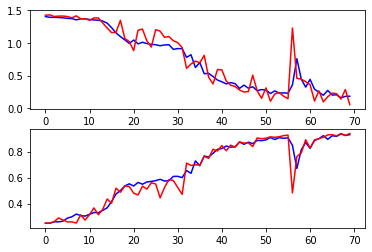

In [25]:
#Plotting the training and validation loss
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')


Confusion matrix, without normalization


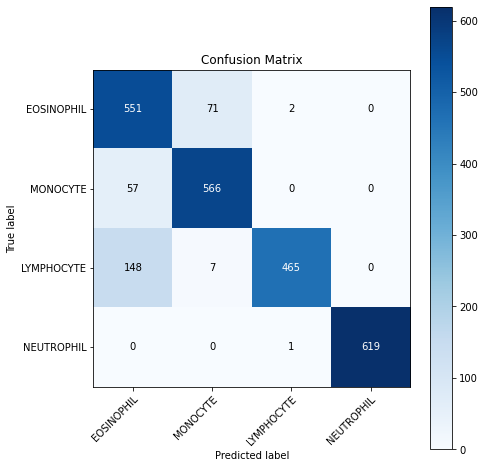

In [39]:
#Making prediction
y_pred3=model.predict(X_test)
y_pred3=np.argmax(y_pred3,axis=1)
y_true=np.argmax(y_test,axis=1)
y_pred3
#Plotting the non normalized confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred3)

class_names={'NEUTROPHIL','EOSINOPHIL','MONOCYTE','LYMPHOCYTE'}
#Plotting non-normalized confusion matrix
plot_confusion_matrix_res(y_true, y_pred3, classes = class_names, title = 'Confusion Matrix')
